In [1]:
#yay imports
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.special import comb
import matplotlib.pyplot as plt
from textwrap import wrap
from IPython.display import HTML
import random

In [2]:
# functs to make stuff look pretty
def wrap_t(text, l, linker = "\n"):
    '''wrapper for breaking long text strings'''
    return linker.join(wrap(text, l))

def plot_params(ax, title,
                x_title=None, 
                y_title=None,
                varied_by = None,
                threshold=None,
                x_len=50,
                y_len=50,
                title_len=50,
                scale='log'):
    '''mini-helper for cleaner axes formatting'''
    
    title = wrap_t(title, title_len) #shorten titles
    
    # conditional wrapping/naming/marking
    if scale:
        ax.set_yscale(scale) # reset scale
    if x_title:
        x_label = wrap_t(x_title, x_len)
        ax.set_xlabel(x_label)
    if y_title:
        y_label = wrap_t(y_title, y_len)
        ax.set_ylabel(y_label)
    if threshold:
        for line in threshold:
            ax.axhline(line)
#         title = f"{title} \n Blue line marks {threshold:.2} thresholds"
    if varied_by:
         plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title = varied_by)

        
    title = wrap_t(title, title_len) #shorten titles
    ax = ax.set_title(title)
#     legend_title = plt.
    
#     legend = plt.legend(handles=[one, two, three], title="title",
#                     loc=4, fontsize='small', fancybox=True)
    
#     plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0, title = "")
    
    
#     legend = plt.legend(handles=[one, two, three], title="title",
#                     loc=4, fontsize='small', fancybox=True)
    return ax

def hide_toggle(for_next=False):
    '''this is for hide/show cells in slide mode'''
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html) 

In [3]:
# notebook wide
sns.set_context("talk", font_scale=.75)
sns.set_style("darkgrid")
threshold_y2 = 1e6 #setting general threshold for OKR # barcodes
threshold_e11 = 1e11

# $n$ choose $k$

* $n$, the total number of elements in a set -- here, the number of available epitopes (=bits)
* $k$, the length of the set chosen from n -- here, the bits expressed per cell

$$
{n \choose k} = \frac{n!}{k! (n-k)!}
$$

Mathematically, maximum ${n \choose k}$ is when $k = \frac{n}{2}$. 

This is also the easiest *imaging* parameter readout -- if a voxel(/cell) has only 5 bits, throw it out. If it has more than 7 bits, also throw it out.

# epitope hungry vs epitope conservative


*Hungry*: In one model of the integrated shifter, each location always expresses 1 of 3 proteins (at equal proportions, biology to be solved). This is computationally much easier, but requires many more rounds of staining.

*Conservative*:In the other, we have a variable number expressed -- each location has single epitope with some % chance of expression. This replicates the math of the analog barcoding system, but at what % do they need to be on/off in order to average $k = \frac{n}{2}$?


## easier case: epitope hungry

1. At each site, there are $c$ (cassette length) bits encoded and 1 expressed.
    e.g. if there are 3 cassettes of 3 or 4 each then
    * total epitopes are: $3*3 = 9 \text{ or }  4*4 = 12$
    * and barcode diversity is: ${3^{3}= 27} \text{ or } 4^{3} = 64$
2. Total epitope requirement $= \text{num sites} * 3$
3. Total diversity is (assuming equal probability) is $c^n$

In [4]:
def integrated_hungry(n = range(1,20,3), sites = range(1,5), model = "epitope_hungry"):
    dfs = []
    if model == "epitope_hungry":
        for epitopes in n:
            df = pd.DataFrame(data = {'sites':sites})
            df['epitopes'] = epitopes
            df['epitopes_per_site'] = df['epitopes']/df['sites']
            
            df['bcs'] = df['epitopes_per_site'] ** df['sites']
            dfs.append(df)
        df = pd.concat(dfs)
        df_evens = df[df['epitopes_per_site'].mod(2) == 0] #evens
        df_odds = df[(df['epitopes_per_site']-1).mod(2) == 0] #odds
        df = df_evens.append(df_odds).reset_index()
        df = df.drop('index', inplace=False, axis=1)
        return df

In [5]:
n = 100
c = 22
df = integrated_hungry(n=range(20,n), sites = range (1, c, 3)) ## this removes any fractional epitope signals

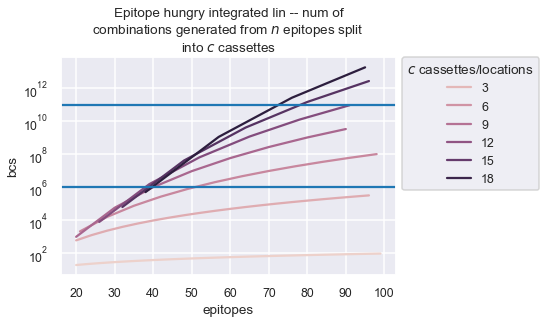

In [6]:
## range of full signal at all rounds across c cassettes and 
ax = sns.lineplot(data = df,
                  x = 'epitopes',
                  y = 'bcs', 
                  hue = "sites")
title = "Epitope hungry integrated lin -- num of combinations generated from $n$ epitopes split into $c$ cassettes"

ax = plot_params(ax, 
                 title,
                 threshold = [threshold_y2, threshold_e11],
                 varied_by = "$c$ cassettes/locations")


hide_toggle()

# Conserving epitope usage 
Harder :)

The probability of any *specific* combination is $P^{k}$.

1. At $c$ sites, there is a probability $P$ of expression. 
2. For $n$ epitopes, the chance of a combo of $n$ (e.g. all expressed, and $k=n$) is $P(bit)\cdot n$
3. For $n$ epitopes, the chance of a combo of $0$ (e.g. none expressed, and $k=0$) is $(P(bit)-1)\cdot n$

Eg for 10 epitopes, $ P = \frac{1}{3}$, a combo of 10 is 
    $$
       \frac{1}{3}^{10} = \frac{1}{3^{10}} = \frac{1}{59049} \approx 0.0000062
    $$
 And for a combo of 0 (no expression):
 $$
      \frac{2}{3}^{10} = \frac{2^10}{3^{10}} = \frac{1024}{59049} \approx 0.017
  $$
  

For a set of epitopes $n$ (here this is the number of ORF shifters integrated total) each epitope has an expression probability $P$ -- random chance in an ORF-shifter system of being turned on. 

The probabilty of a set of length $k$ being expressed is:
$$ P^{k}\cdot (P-1)^{n-k}$$

The total number of barcodes potentially generated is the number of potential combinations e.g. 
$$P^{k}\cdot (P-1)^{n-k} \cdot  {n \choose k}$$

In [42]:
## ok let's do the math guys!!!!
# set variables


In [43]:
## actually we can re use this! and then just generate probabilities on top of the thing we already have ookkkaaayyy!

def vary(n,k):
    return comb(n, k, repetition=False) #combine without repete

def make_combinatorics(n = range(0,60,1), k = range(1, 20)):
    ks = k
    dfs = []
    for k in ks:
        df = pd.DataFrame(data = {'n':n})
        df['k'] = k
        df['num_unique'] = df['n'].apply(lambda n : vary(n, k))
        dfs.append(df)
    df = pd.concat(dfs)
    df = df.reset_index().drop('index', inplace=False, axis=1)

    return df

def prob_specific_combo(p, k):
    return (p**k)

In [71]:
p = .7 #prob. of epitope expressing
n = 40 #number of potential epitopes

df = make_combinatorics(n=range(1,n+1,4), k = range(1,n+1,4))
df = df.query("num_unique > 0").copy()
df['p'] = p

In [72]:
df['prob_individual_len_k'] = df.apply(lambda x: prob_specific_combo(x.p, x.k), axis=1)
df['num_possible'] = df['prob_individual_len_k']*df['num_unique']

In [82]:
df.groupby("n").agg('sum')

,k,num_unique,p,prob_individual_len_k,num_possible
n,,,,,
1,1,1.000000e+00,0.7,0.700000,7.000000e-01
5,6,6.000000e+00,1.4,0.868070,3.668070e+00
9,15,1.360000e+02,2.1,0.908424,2.751717e+01
13,28,2.016000e+03,2.8,0.918113,2.542686e+02
17,45,3.289600e+04,3.5,0.920439,2.055975e+03
21,66,5.237760e+05,4.2,0.920997,1.728141e+04
25,91,8.390656e+06,4.9,0.921131,1.442968e+05
29,120,1.342095e+08,5.6,0.921164,1.204774e+06
33,153,2.147516e+09,6.3,0.921171,1.006397e+07


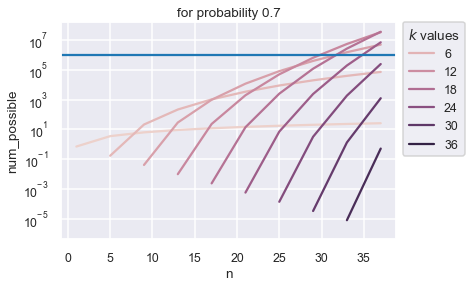

In [76]:
## the ful range of varying n, constrained k
ax = sns.lineplot(data = df,
                  x = 'n',
                  y = 'num_possible',
                  hue = "k")
title = f"for probability {p}"


ax = plot_params(ax, 
                 title,
                 threshold = [threshold_y2], 
                 varied_by = "$k$ values")


# hide_toggle()


## Poisson distribution


This math assumes no replacement -- i.e. we are only counting the number of sets of length $k$, not any of the other potential sets generated in a Poisson distribution of $k$ delivered to each cell.

* CasTag is a controlled length $k$
* original episomal delivery is Poisson (requires delivering 20 and only 20 viral genomes/cell from a pool of 40)
    * if we are *including* voxels of varying $k$, diversity increases, but introduces dropout confound of dropout -- is this a 5-bit cell, or a bad round of antibody staining?
    
---

# $n$ choose $k$ without replacement (sets with exactly $k$ unique elements)

In [ ]:
def vary(n,k):
    return comb(n, k, repetition=False) #combine without repete

def make_combinatorics(n = range(0,60,1), k = range(3, 20)):
    ks = k
    dfs = []
    for k in ks:
        df = pd.DataFrame(data = {'n':n})
        df['k'] = k
        df['num_unique'] = df['n'].apply(lambda n : vary(n, k))
        dfs.append(df)
    df = pd.concat(dfs)
    return df.reset_index()

In [ ]:
## df test
df = make_combinatorics(n=range(5,40,1), k = range(3,40,1))
df.head(10)

# variable $n$, constrained $k$

In [ ]:
df = make_combinatorics(n=range(1,40,1), k = range(1,25,1))

In [ ]:
## the ful range of varying n, constrained k
ax = sns.lineplot(data = df,
                  x = 'n',
                  y = 'num_unique', 
                  hue = "k")
title = "Unique sets of length $k$ across total pool of barcoding elements $n$"

ax = plot_params(ax, 
                 title,
                 threshold = threshold, 
                 varied_by = "$k$ values")


# hide_toggle()

In [ ]:
# ax = sns.lineplot(data = df,
#                   x = 'n',
#                   y = 'num_unique', 
#                   hue = "k")
# ax = plot_params(x,)
# ax.axhline(threshold)


# ax = ax.set_title(f"Varying n across constrained set length k. \
# \nBlue line indicates {threshold:.2} unique codes")

In [ ]:
# subsampling for constrained k

select = range(0, 20, 5) #select a subset of k in sets of whatever
df_ = df[df['k'].isin(select)] #use this frame from here on out!

hue_var = "k"
ax = sns.lineplot(data = df_,
                  x = 'n',
                  y = 'num_unique',
                  hue = hue_var)

title = "Unique sets of length $k$ across total pool of barcoding elements n."
x = "n, epitope pool size"
y = "y, number of unique equal length sets"

ax = plot_params(ax, title,
                 x, y, f"${hue_var}$ values",
                 threshold, 
                 y_len = 20
                 )

hide_toggle()

In [ ]:
# ax = sns.lineplot(data = df[df['solved']], x = 'n', y = 'num_unique', hue = "k")
# ax.set_yscale('log')
# ax.axhline(threshold)
# ax = ax.set_title(f"values of n choose k that solve the {threshold:.2}")

# varying $k$ with constrained $n$

In [ ]:
df = make_combinatorics(n=range(1,50,1), k = range(1,40,1))

In [ ]:
### values as k varies with constrained n
hue_var = "n"
title = f"Unique expressed sets as ${hue_var}$ varies."
x = "$k$, length of expressed set"
y = "y, number of unique equal length sets"

ax = sns.lineplot(data=df,
                  x='k',
                  y='num_unique',
                  hue=hue_var)
ax = plot_params(ax, title,
                 x, y, f"${hue_var}$",
                 threshold, 
                 y_len = 20,
#                  scale = ,
                 )

hide_toggle()

In [ ]:
### sampling unique across k and holding n steady
select = range(10, 40, 10)
df_ = df[df['n'].isin(select)]

title = "Diversity as $n$ varies."
# Diversity is maximized when $k=n/2$: each set sampling half the possible pool"
x = "$k$, length of expressed set"
y = "y, number of unique equal length sets"
hue_var = "n"

ax = sns.lineplot(data = df_, x = 'k', y = 'num_unique', hue = hue_var)
ax = plot_params(ax, title,
                 x, y, f"${hue_var}$",
                 threshold, 
#                  scale = None,
                 y_len = 20
                 )
hide_toggle()


# Synthesis constraints: cassette lengths and shuffled assembly
___

Given synthesis constraints, we can fit 3-4 epitopes on a single oligo synthesis as part of an oligo pool.

However, we can combine cassettes (i.e. synthesize each cassette, bit length 3-4, and then assemble into a larger set of expressed epitopes).

With some number of cassettes $c$, diversity is now ${\frac{n}{c} \choose k}$, and requires $n\times c$ epitopes. 
This lets us reach more unique barcodes while maintaining a 3 or 4 bit synthesis & dropping the number of epitopes needed significantly (the point where $n \choose 3$ = 1e6).

* not currently accounting for collisions in unique space or bias in the biological assembly components

# $k$-bits at $c$ sites

In [ ]:
def apply_cassette_math(unique_in_cassette, n_col, num_cassettes):
    return pd.Series([unique_in_cassette**num_cassettes, #unique cassettets from n choose k
                      n_col*num_cassettes, ##num epitopes needed
                      num_cassettes]) #num cassettes we're mathing

In [ ]:
def cassette_comb(df, c = range(1,5,1)):
    '''iteratively apply cassette math for differing values of c'''
    cs = c
    dfs = []
    for c in cs:
        _df = df.copy()
        _df[['total_diversity',
           'total_epitopes_needed',
           'c']] = df.apply(lambda x: cassette_math(x['num_unique'],
                                                    x['n'],
                                                    c), axis=1)
        dfs.append(_df)
    new_df = pd.concat(dfs)
    return new_df.reset_index()

In [ ]:
df = make_combinatorics(n=range(1,20,1), k = range(3,9,1)) #make combinatorics df
df = cassette_comb(df) #this is a little weird actually but workable

In [ ]:
## plotting at a selection of k
_df = df[df['c'].isin([2,4])]
_df = _df[_df['k'].isin([3,4])]

_df = _df[_df['total_epitopes_needed'] <= 40]

## plotting for real

hue_var = "c"
ax = sns.lineplot(data = _df,
                  y = 'total_diversity',
                  x = 'total_epitopes_needed',
                  style = "k",
                  hue = 'c')

title = f"Unique sets from $n/c$ choose $k$ (i.e. $c$ pools of non-overlapping $n$, and assembled for final $k*c$ bit expressed set)."
x = f"$n$, number of total epitopes required (split between $c$ pools)"
y = "y, number of unique expressed sets"

# ax.set_ylim(0, 10e9)

ax = plot_params(ax, title,
                 x, y, f"${hue_var}$",
                 threshold, 
                 y_len = 20)

hide_toggle()

# $k$-bits at 3 sites
Where each synthesis is 3 epitopes at 3 locations

In [ ]:
## math for 3 cassettes
df = make_combinatorics(n=range(1,40,1), k = range(2,16,1))
num_cassettes = 3

df['total_diversity'] = df['num_unique']**num_cassettes
df['total_epitopes_needed'] = df['n']*num_cassettes
df['assembly_solved'] = df['total_diversity'].apply(lambda x : x>threshold)
df['solved'] = df['num_unique'].apply(lambda x : x>threshold)

In [ ]:
##plotting

_df = df[df['k'].isin([2,3,4])]

hue_var = "k"
ax = sns.lineplot(data = _df,
                  y = 'total_diversity',
                  x = 'total_epitopes_needed',
                  hue = hue_var)



title = f"Unique sets from $n/{num_cassettes}$ choose $k$ (i.e.\
{num_cassettes} pools comprised of non-overlapping $n$, and all\
possible assembled for a final of a $k$*{num_cassettes} bit expressed set)."
x = f"$n$, number of total epitopes required (split between {num_cassettes} pools)"
y = "y, number of unique expressed sets"


ax = plot_params(ax, title,
                 x, y, f"${hue_var}$",
                 threshold, 
                 y_len = 20
                 )
# hide_toggle()





# ax = sns.lineplot(data = _df,
#                   y = 'total_diversity',
#                   x = 'total_epitopes_needed',
#                   hue = "k")

# title = "Unique sets from n/2 choose k (i.e. two part random-shuffle assembly).\n\
# Combinatorics addressing synthesis length (assuming 300 bp from Twist)."
# x = "n, number of total epitopes required for assembly"
# y = "y, number of unique sets"

# ax = plot_params(ax, title, x, y, threshold, y_len=20, x_len = 20)
# hide_toggle()


In [ ]:
## scratch work below this

# $n$ choose $k$ with replacement -- $ \left( n \choose k \right)$
* in analysis, if set length isn't controlled we _can_ deal with that (just more difficult) -- introduces concept of dropout
* _but_ gives us the integral -- diversity is all set lengths -- n choose k with replacement, rather

* https://www.johndcook.com/blog/select_with_replacement/

In [ ]:
def vary_r(n,k):
    return comb(n, k, repetition=True) #combine with repeats

def make_combinatorics_r(n = range(0,60,1), k = range(3, 20)):
    ks = k
    dfs = []
    for k in ks:
        df = pd.DataFrame(data = {'n':n})
        df['k'] = k
        df['num_unique'] = df['n'].apply(lambda n : vary_r(n, k))
        dfs.append(df)
    df = pd.concat(dfs)
    return df.reset_index()

In [ ]:
## df test
df = make_combinatorics_r(n=range(5,40,1), k = range(3,40,1))
df.head(10)

# variable $n$, constrained $k$

In [ ]:
df = make_combinatorics_r(n=range(1,40,1), k = range(1,40,1))

In [ ]:
## the ful range of varying n, constrained k
ax = sns.lineplot(data = df,
                  x = 'n',
                  y = 'num_unique', 
                  hue = "k")
title = "Unique sets of up to length k across total pool of barcoding elements $n$"

ax = plot_params(ax, 
                 title,
                 threshold = threshold, 
                 varied_by = "$k$ values")


# hide_toggle()

In [ ]:
# ax = sns.lineplot(data = df,
#                   x = 'n',
#                   y = 'num_unique', 
#                   hue = "k")
# ax = plot_params(x,)
# ax.axhline(threshold)


# ax = ax.set_title(f"Varying n across constrained set length k. \
# \nBlue line indicates {threshold:.2} unique codes")

In [ ]:
# subsampling for constrained k

select = range(0, 40, 10) #select a subset of k in sets of whatever
df_ = df[df['k'].isin(select)] #use this frame from here on out!

hue_var = "k"
ax = sns.lineplot(data = df_,
                  x = 'n',
                  y = 'num_unique',
                  hue = hue_var)

title = "Unique sets up to length $k$ across total pool of barcoding elements $n$."
x = "n, epitope pool size"
y = "y, number of unique equal length sets"

ax = plot_params(ax, title,
                 x, y, f"${hue_var}$ values",
                 threshold, 
                 y_len = 20
                 )

hide_toggle()

In [ ]:
# ax = sns.lineplot(data = df[df['solved']], x = 'n', y = 'num_unique', hue = "k")
# ax.set_yscale('log')
# ax.axhline(threshold)
# ax = ax.set_title(f"values of n choose k that solve the {threshold:.2}")

# varying $k$ with constrained $n$

In [ ]:
df = make_combinatorics_r(n=range(1,50,1), k = range(3,40,1))

In [ ]:
### values as k varies with constrained n
hue_var = "n"
title = f"Unique expressed sets as ${hue_var}$ varies."
x = "$k$, length of expressed set"
y = "y, number of unique equal length sets"

ax = sns.lineplot(data=df,
                  x='k',
                  y='num_unique',
                  hue=hue_var)
ax = plot_params(ax, title,
                 x, y, f"${hue_var}$",
                 threshold, 
                 y_len = 20
                 )

hide_toggle()

In [ ]:
### sampling unique across k and holding n steady
select = range(10, 50, 10)
df_ = df[df['n'].isin(select)]

title = "Diversity as $n$ increases."
x = "$k$, length of expressed set"
y = "y, number of unique equal length sets"
hue_var = "n"

ax = sns.lineplot(data = df_, x = 'k', y = 'num_unique', hue = hue_var)
ax = plot_params(ax, title,
                 x, y, f"${hue_var}$",
                 threshold, 
                 y_len = 20
                 )
hide_toggle()


# Synthesis constraints: cassette lengths and shuffled assembly
___

Given synthesis constraints, we can fit 3-4 epitopes on a single oligo synthesis as part of an oligo pool.

However, we can combine cassettes (i.e. synthesize each cassette, bit length 3-4, and then assemble into a larger set of expressed epitopes).

With some number of cassettes $c$, diversity is now ${\frac{n}{c} \choose k}$, and requires $n\times c$ epitopes. 
This lets us reach more unique barcodes while maintaining a 3 or 4 bit synthesis & dropping the number of epitopes needed significantly (the point where $n \choose 3$ = 1e6).

* not currently accounting for collisions in unique space or bias in the biological assembly components

# $k$-bits at two locations

In [ ]:
## math for cassette combinatorics
num_cassettes = 2
df = make_combinatorics_r(n=range(1,40,1), k = range(3,20,1))
df['total_diversity'] = df['num_unique']**num_cassettes
df['total_epitopes_needed'] = df['n']*num_cassettes
df['assembly_solved'] = df['total_diversity'].apply(lambda x : x>threshold)
df['solved'] = df['num_unique'].apply(lambda x : x>threshold)

In [ ]:
## plotting at a selection of k
select = range(0, 20, 5)
_df = df[df['k'].isin(select)]

hue_var = "k"
ax = sns.lineplot(data = _df,
                  y = 'total_diversity',
                  x = 'total_epitopes_needed',
                  hue = hue_var)

title = f"Unique sets from $n/{num_cassettes}$ choose $k$ with replacement (i.e. two \
pools comprised of non-overlapping $n$), where each pool is between 1 and $k$ bits long."
x = f"$n$, number of total epitopes required (split between {num_cassettes} pools)"
y = "y, number of unique expressed sets"

ax = plot_params(ax, title,
                 x, y, f"${hue_var}$",
                 threshold, 
                 y_len = 20)
hide_toggle()


# $k$-bits at 3 sites
Where each synthesis is 3 epitopes at 3 locations

In [ ]:
## math for 3 cassettes
df = make_combinatorics(n=range(1,40,1), k = range(2,16,1))
num_cassettes = 3

df['total_diversity'] = df['num_unique']**num_cassettes
df['total_epitopes_needed'] = df['n']*num_cassettes
df['assembly_solved'] = df['total_diversity'].apply(lambda x : x>threshold)
df['solved'] = df['num_unique'].apply(lambda x : x>threshold)

In [ ]:
##plotting

_df = df[df['k'].isin([2,3,4])]

hue_var = "k"
ax = sns.lineplot(data = _df,
                  y = 'total_diversity',
                  x = 'total_epitopes_needed',
                  hue = hue_var)



title = f"Unique sets from $n/{num_cassettes}$ choose $k$ (i.e.\
{num_cassettes} pools comprised of non-overlapping $n$, and all\
possible assembled for a final of a $k$*{num_cassettes} bit expressed set)."
x = f"$n$, number of total epitopes required (split between {num_cassettes} pools)"
y = "y, number of unique expressed sets"


ax = plot_params(ax, title,
                 x, y, f"${hue_var}$",
                 threshold, 
                 y_len = 20
                 )
# hide_toggle()





# ax = sns.lineplot(data = _df,
#                   y = 'total_diversity',
#                   x = 'total_epitopes_needed',
#                   hue = "k")

# title = "Unique sets from n/2 choose k (i.e. two part random-shuffle assembly).\n\
# Combinatorics addressing synthesis length (assuming 300 bp from Twist)."
# x = "n, number of total epitopes required for assembly"
# y = "y, number of unique sets"

# ax = plot_params(ax, title, x, y, threshold, y_len=20, x_len = 20)
# hide_toggle()


In [ ]:
min_df = df[df['solved']].groupby("n").min().reset_index()

In [ ]:
df[df['assembly_solved']].groupby("n").min()

In [ ]:
min_df.sort_values('n')

In [ ]:
ax = sns.relplot(x='k', y='n', data=min_df)
# ax.set_title(f"minimum nCk combo\nthat crosses {threshold:e} threshold")

In [ ]:
# min_df = df[df['solved it! assembly']].groupby('epitope_ct_needed').min().reset_index()

In [ ]:
#min_df = df[df['solved it! assembly']].groupby().min().reset_index()

In [ ]:
#min_df.sort_values("epitope_ct_needed")

In [ ]:
ax = sns.scatterplot(x='k', y='epitope_ct_needed', data=min_df)
ax.set_title(f"minimum # of a n/k combo that crosses {threshold} threshold")

In [ ]:
min_df = df[df['solved it!']].groupby('k').min().sort_values('k').reset_index()
min_df

# when does [x choose 3]^2 cross threshold

In [ ]:
ax = sns.scatterplot(x='n', y='k', data=min_df)
ax.set_title(f"minimum nCk combo\nthat crosses {threshold:e} threshold")